In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt

In [3]:

#created variales for images size
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=1
EPOCHS=50

In [5]:
# added code to convert images to grayscale
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/NEWmangoDATASET/diseasemango",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 2995 files belonging to 7 classes.


In [7]:
# apply the grayscale conversion to the dataset
dataset = dataset.map(convert_to_grayscale)

In [8]:
import os

data_dir = '/content/drive/MyDrive/NEWmangoDATASET/diseasemango'
class_names = sorted(os.listdir(data_dir))
print(class_names)

['Bacterial_Canker', 'Healthy  leaf', 'Healthy leaf', 'Sooty Mould  Leaf', 'Sooty Mould leaf', 'anthracnose  leaf', 'anthracnose leaf']


In [9]:
len(dataset)

94

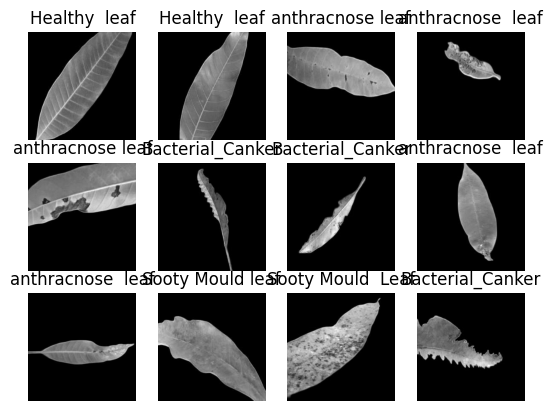

In [10]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap="gray")
        plt.title(class_names[label_batch[i]])
        # to turn off the axis points
        plt.axis("off")
        
        
    

In [11]:
#SPLITTING DATASET
#80 for training
# 20 for validation
#10 for tetsing
train_size=0.8
len(dataset)*train_size


75.2

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

40

In [14]:
val_size=0.1
len(dataset)*val_size

9.4

In [15]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

34

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

75

In [20]:
len(val_ds)

9

In [21]:
len(test_ds)

10

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [23]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 1)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
75/75 [==============================] - 702s 216ms/step - loss: 1.7865 - accuracy: 0.2631 - val_loss: 1.8842 - val_accuracy: 0.2326
Epoch 2/25
75/75 [==============================] - 9s 120ms/step - loss: 1.4434 - accuracy: 0.4101 - val_loss: 1.8041 - val_accuracy: 0.3368
Epoch 3/25
75/75 [==============================] - 9s 124ms/step - loss: 1.2649 - accuracy: 0.4822 - val_loss: 1.5285 - val_accuracy: 0.3576
Epoch 4/25
75/75 [==============================] - 10s 135ms/step - loss: 1.1539 - accuracy: 0.5224 - val_loss: 1.3973 - val_accuracy: 0.4757
Epoch 5/25
75/75 [==============================] - 10s 135ms/step - loss: 1.1317 - accuracy: 0.5312 - val_loss: 1.5563 - val_accuracy: 0.4514
Epoch 6/25
75/75 [==============================] - 9s 122ms/step - loss: 1.0552 - accuracy: 0.5739 - val_loss: 1.0644 - val_accuracy: 0.5868
Epoch 7/25
75/75 [==============================] - 9s 124ms/step - loss: 1.0654 - accuracy: 0.5760 - val_loss: 1.3110 - val_accuracy: 0.5243
Ep

In [30]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 5s 24ms/step - loss: 0.4388 - accuracy: 0.8531


In [31]:
scores

[0.4387795031070709, 0.8531249761581421]

In [32]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 75}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

25

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.7864705324172974,
 1.4434428215026855,
 1.2649198770523071,
 1.1538951396942139,
 1.1316887140274048]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

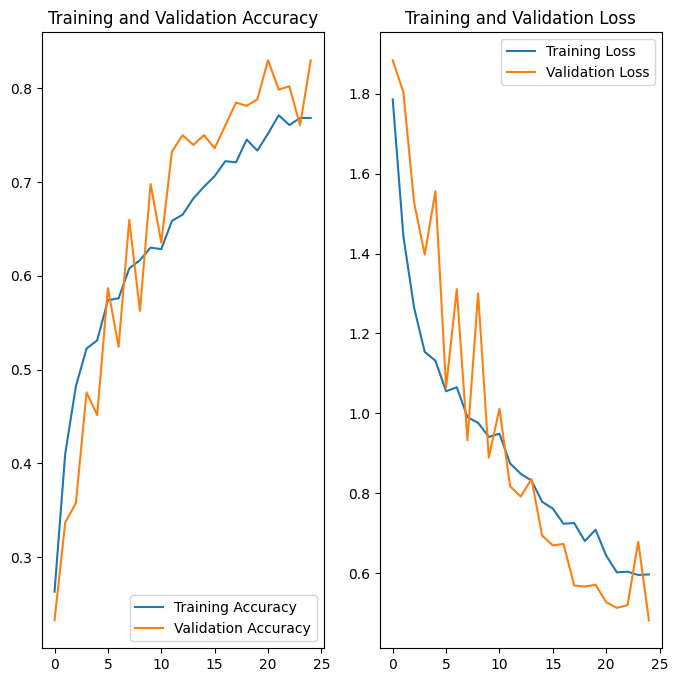

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model.save("/content/drive/MyDrive/NEWmangoDATASET/models/sg2new.h5")

first image to predict
actual label: anthracnose  leaf
1/1 [==============================] - 0s 174ms/step
predicted label: anthracnose  leaf


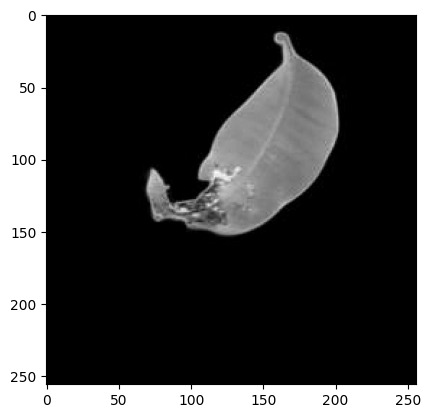

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image, cmap="gray")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


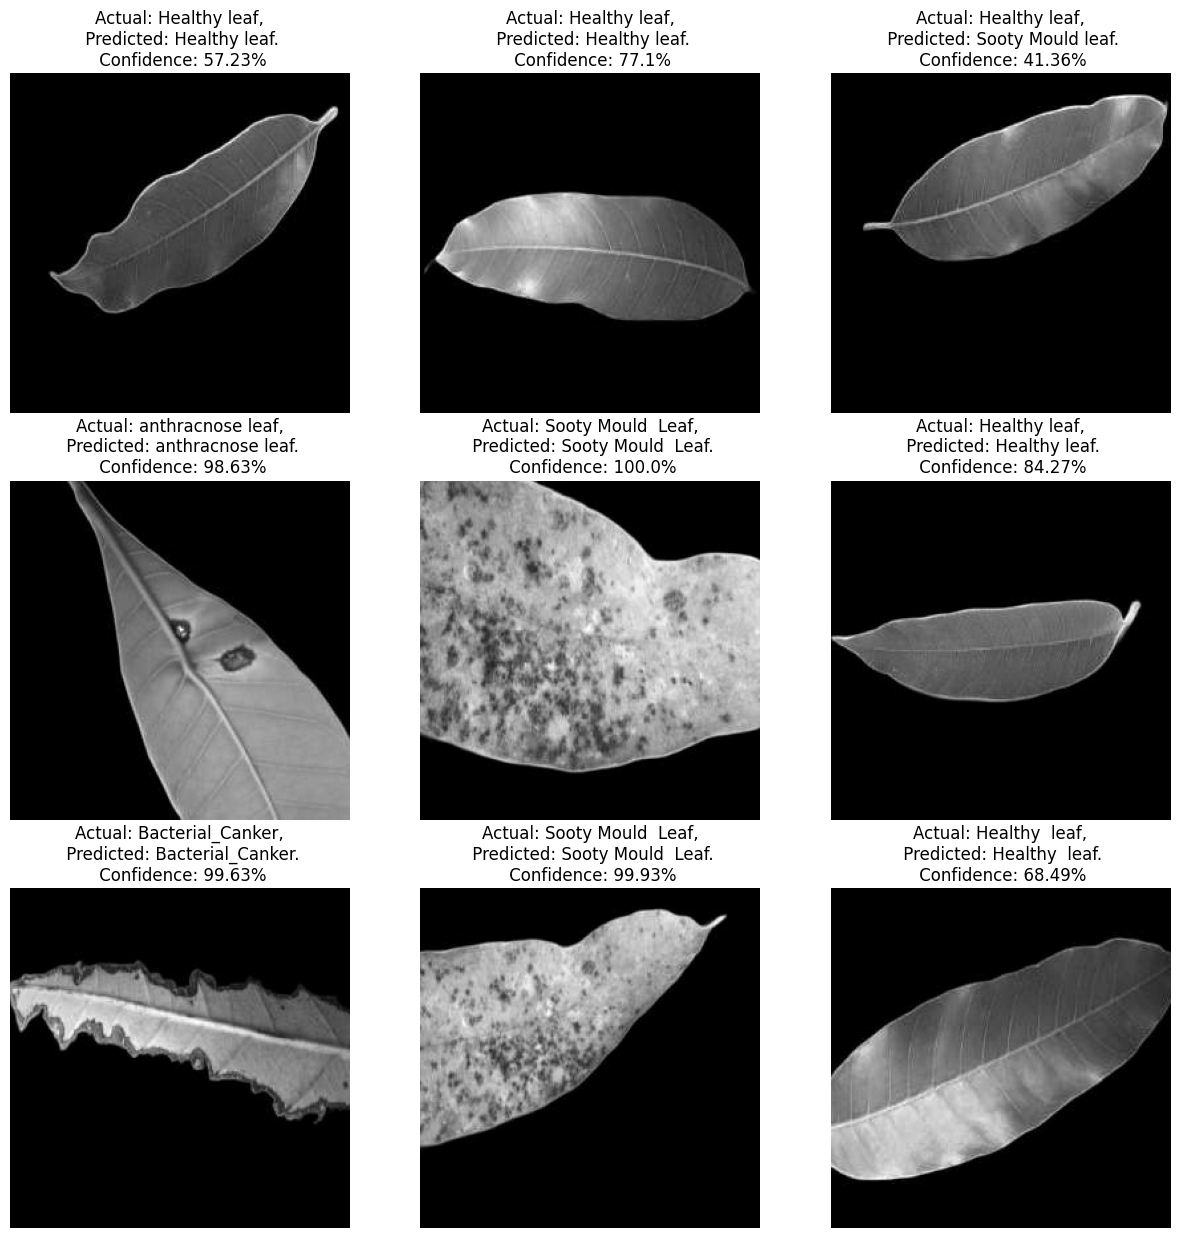

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")